**1. Detection:**

In [1]:
# System & image handling
import os
import glob
import random
import warnings
from PIL import Image  # Image processing

# Data & plotting
import numpy as np      # Array handling
import pandas as pd     # Dataframes
import seaborn as sns   # Visualization
import matplotlib.pyplot as plt  # Plotting

# ML utilities
from sklearn.utils import shuffle  # Shuffle data
from sklearn.model_selection import train_test_split  # Split data

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping  # Stop early if no improvement

# Image processing
import cv2  # Image read/resize

# Set custom Keras path (for Kaggle)
os.environ['KERAS_HOME'] = '/kaggle/working/.keras'
os.makedirs('/kaggle/working/.keras', exist_ok=True)

# Suppress warnings/logs
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


2025-04-20 01:11:44.269322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745111504.461806      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745111504.514624      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_No = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
path_Yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'

tumor = []
no_tumor = []
random_state = 42

# Load and process images with tumor
for file in glob.iglob(path_Yes):
    img = cv2.imread(file)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (128, 128))  # Resize image to 128x128
    tumor.append((img, 1))  # Label 1: tumor present

# Load and process images without tumor
for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Label 0: no tumor

# Combine both datasets and shuffle later
all_data = tumor + no_tumor

# Separate images and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])


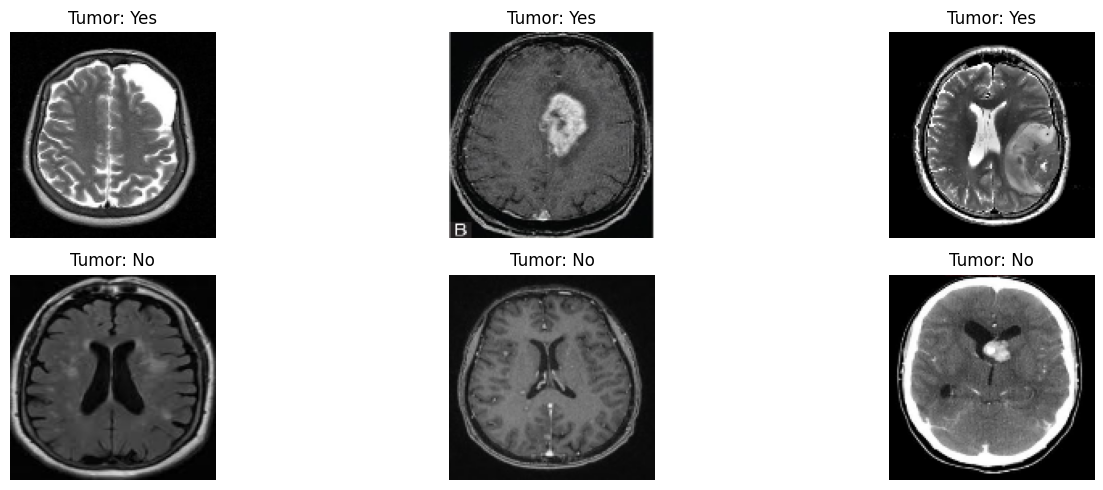

In [3]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

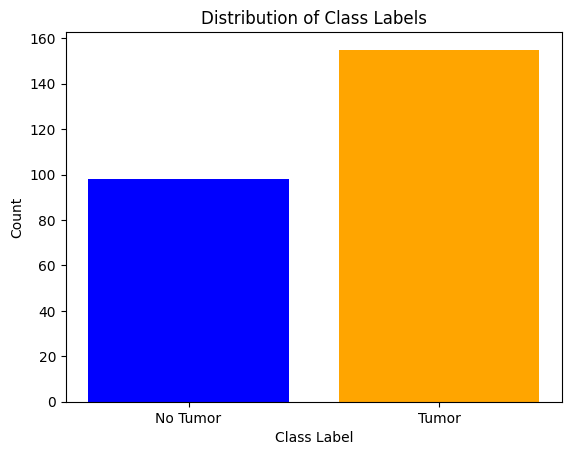

In [4]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [5]:
# Split dataset into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

# Normalize the pixel values to the range [0, 1] by dividing by 255
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
# Print the minimum and maximum pixel values after normalization
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:", x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [7]:
model = Sequential()  # Initialize a sequential model

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))  # First convolutional layer with 32 filters
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial size with 2x2 pooling

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))  # Second convolutional layer with 64 filters
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))  # Third convolutional layer with 128 filters
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer

model.add(Flatten())  # Flatten the feature maps to 1D vector
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 neurons
model.add(Dropout(0.5))  # Another dropout layer

model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification (tumor or no tumor)


I0000 00:00:1745111520.448019      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
model.compile(optimizer='Adam',  # Uses Adam optimizer for efficient training
              loss='binary_crossentropy',  #  measuring how well the model is performing in binary classification problems
              metrics=['accuracy'])  # Tracks accuracy during training

In [9]:
model.summary()  # Displays a summary of the model architecture including the layers, their output shapes, and the number of parameters.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define a custom callback function
class myCallback(tf.keras.callbacks.Callback):
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        # Check if the accuracy has exceeded 99%
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")  # Print a message
            self.model.stop_training = True  # Stop the training process

# Instantiate the callback object
back = myCallback()

In [11]:
# Train the model
history = model.fit(x_train,            # Training images
                    y_train,            # Labels (0 or 1)
                    epochs=100,         # Training loops
                    batch_size=32,      # Samples per update
                    validation_split=0.2,  # 20% for validation
                    callbacks=[back])   # Stop if accuracy > 99%

# Loss is used to adjust weights — no explicit distance calculation.


Epoch 1/100


I0000 00:00:1745111524.386312      66 service.cc:148] XLA service 0x781e280063e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745111524.387012      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745111524.703525      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/6 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.5625 - loss: 0.6903

I0000 00:00:1745111527.864946      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - accuracy: 0.6573 - loss: 0.6344 - val_accuracy: 0.5610 - val_loss: 0.6797
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6151 - loss: 0.6115 - val_accuracy: 0.6098 - val_loss: 0.5783
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7758 - loss: 0.5239 - val_accuracy: 0.8293 - val_loss: 0.5804
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7044 - loss: 0.5757 - val_accuracy: 0.6341 - val_loss: 0.5682
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7805 - loss: 0.5589 - val_accuracy: 0.7561 - val_loss: 0.5223
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7379 - loss: 0.5307 - val_accuracy: 0.7561 - val_loss: 0.5163
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8036 - loss: 0.4334 - val_accuracy: 0.8293 - val_loss: 0.5125
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8289 - loss: 0.4341 - val_accuracy: 0.8293 - val_loss: 0.5355
Epo

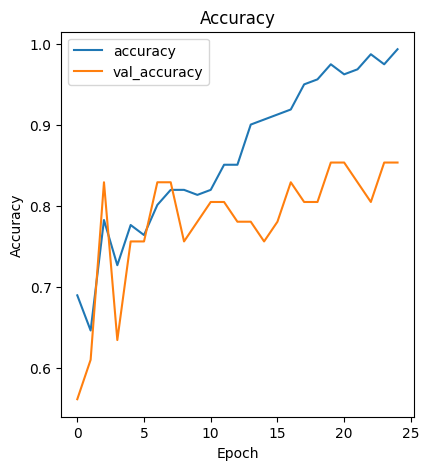

In [12]:
# plot the accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

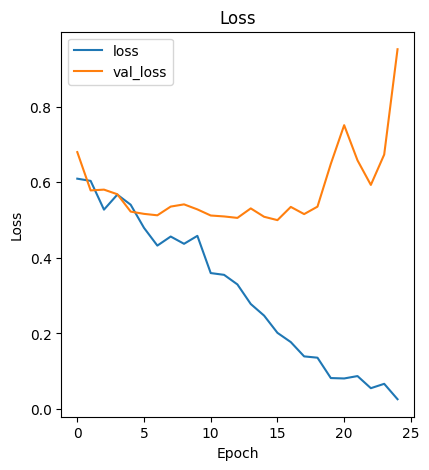

In [13]:
# model loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8903 - loss: 0.6398
Test Loss: 0.6449605822563171
Test Accuracy: 0.8823529481887817


In [15]:
# Assuming 'model' is your trained Keras model
model.save("brain_tumor.h5")

In [16]:
#test_model
test_image_path = '/kaggle/input/image-mri/images.jpeg'

In [17]:
# Load image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

# Normalize pixel values
img = img / 255.0

# Reshape for model prediction: (1, 128, 128, 3)
img_input = np.expand_dims(img, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


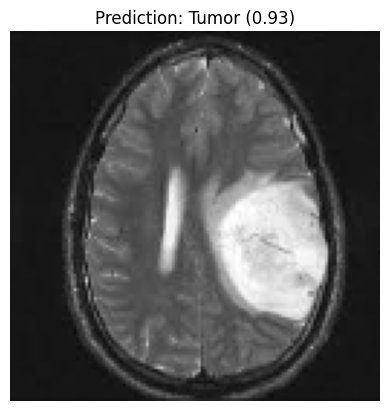

In [18]:
# Predict the class (0 = No Tumor, 1 = Tumor)
prediction = model.predict(img_input)

# Convert to readable label
label = 'Tumor' if prediction[0][0] > 0.5 else 'No Tumor'

# Display result
plt.imshow(img)
plt.title(f"Prediction: {label} ({prediction[0][0]:.2f})")
plt.axis('off')
plt.show()

**2. Segmentation:**

In [19]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# File and image handling
import os
from glob import glob
import cv2

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_dilation

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Image transforms
import torchvision
from torchvision import transforms
import albumentations as A

# Metrics for model evaluation
import torchmetrics as tm

# Timing and progress bar
import time
from tqdm import tqdm


In [20]:
# Set device variable
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

# Random control
RANDOM_SEED = 42

# Main path
MAIN_PATH = "/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m"

In [21]:
#prepare data
csv_path = os.path.join(MAIN_PATH, "data.csv")
df = pd.read_csv(csv_path)

In [22]:
def get_file(path: str):
    """Returns a list containing:
    - Patient ID extracted from the filename
    - Image file path
    - Corresponding mask file path (assuming mask has same name + '_mask')"""
    path_no_ext, ext = os.path.splitext(path)              # Separate file path and extension
    filename = os.path.basename(path)                      # Get file name only (without directories)
    patient_id = "_".join(filename.split("_")[:3])         # Extract patient ID from filename
    return [patient_id, path, f"{path_no_ext}_mask{ext}"]  # Return [ID, image path, mask path]


def get_data_dir_list(path: str):
    """Returns a list of all image file paths in subfolders (with .tif extension and digits in name)"""
    return glob(f"{path}/*/*[0-9].tif")  # Searches for .tif files in nested folders

In [23]:
# Create a DataFrame with patient ID, image path, and mask path
path_df = pd.DataFrame((get_file(file) for file in get_data_dir_list(MAIN_PATH)),
                       columns=["Patient", "image", "mask"])

# Merge with another DataFrame `df` using the patient ID as the key
df = pd.merge(df, path_df, on="Patient")

In [24]:
# Split data into train (85%) and test (15%) sets
train_df, test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)

# Further split test set into validation (30% of 15%) and final test set
test_df, valid_df = train_test_split(test, test_size=0.3, random_state=RANDOM_SEED)

# Print number of samples in each set
print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 3339 | Validation: 177 | Test: 413


In [25]:
def visualize_batch(batch: tuple):
    """
    Display images and their corresponding masks from a batch.
    """
    images, masks = batch
    
    for index in range(len(images)):
        plt.figure(figsize=(10, 10))
        mask = masks[index].numpy()
        image = images[index].permute(1, 2, 0).numpy()  # Convert tensor to HWC for plotting

        plt.subplot(1, 3, 1)
        plt.imshow(mask)
        plt.title("Ground Truth Mask")

        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.5)  # Overlay mask on top of the image with transparency
        plt.title("Overlayed Image")

        plt.show()

def plot_statistics(**statistic_lists):
    """
    Plot training and test statistics (like loss or accuracy).
    """
    for index, (name, statistic_list) in enumerate(statistic_lists.items()):
        plt.figure(figsize=(12,8))
        label_name = name.split(' ')[0]
        plt.plot(statistic_list[0], label=f'Training {label_name}')
        plt.plot(statistic_list[1], label=f'Test {label_name}')
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.legend()


In [26]:
class MRI_Dataset(Dataset):
    # Initialize the dataset with a dataframe, optional transformations, and metadata tensor
    def __init__(self, 
                 df: pd.DataFrame,   # DataFrame containing image and mask paths
                 transform: A.Compose = None,   # Optional transformations (e.g., augmentation)
                 metadata_tensor: torch.Tensor = None):  # Optional additional metadata
        super(MRI_Dataset, self).__init__()  # Call the parent class's constructor
        self.df = df  # Store the dataframe
        self.transform = transform  # Store the transformations (if any)
        self.metadata_tensor = metadata_tensor  # Store metadata tensor (if any)
        
    # Return the number of samples in the dataset
    def __len__(self):
        return len(self.df)

    # Return a string representation of the dataset
    def __str__(self):
        return f'<MRI_Dataset> with {len(self.df)} data'
        
    # Get a specific data sample (image and mask) by index
    def __getitem__(self, idx):
        row = self.df.iloc[idx]  # Get the row from the dataframe at the specified index
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)  # Read the image (MRI scan)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)  # Read the mask (segmentation mask)
        
        # Apply transformations (if any) to both image and mask
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)  # Apply augmentations
            image, mask = augmented['image'], augmented['mask']  # Unpack augmented image and mask
        
        img = transforms.functional.to_tensor(img)  # Convert the image to a tensor
        mask = mask // 255  # Normalize the mask (convert pixel values to 0 or 1)
        mask = torch.Tensor(mask)  # Convert the mask to a tensor

        # If metadata tensor is provided, return it along with image and mask
        if self.metadata_tensor is not None:
            metadata = self.metadata_tensor[idx]  # Get the metadata corresponding to this sample
            return img, mask, metadata  # Return the image, mask, and metadata
        
        return img, mask  # Otherwise, just return the image and mask


In [27]:
# Define a series of image augmentation transformations using Albumentations
transform = A.Compose([
    A.ChannelDropout(p=0.3),  # Randomly drops channels in the image with a probability of 30%
    A.RandomBrightnessContrast(p=0.3),  # Randomly adjust brightness and contrast of the image with a probability of 30%
    A.ColorJitter(p=0.3),  # Randomly adjust the color properties of the image (like brightness, saturation, hue) with a probability of 30%
])

# Initialize MRI_Dataset objects for training, validation, and test sets
train_dataset = MRI_Dataset(train_df, transform)  # Training dataset with augmentation applied
valid_dataset = MRI_Dataset(valid_df)  # Validation dataset without augmentation
test_dataset = MRI_Dataset(test_df)  # Test dataset without augmentation

# Set the batch size for loading data
batch_size = 16

# Initialize DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
# DataLoader handles batching, shuffling, and parallelization. Here, shuffle=True ensures randomization in the order of training data.

# Initialize DataLoader for validation set
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  
# Validation set is also shuffled for better performance and generalization.

# Initialize DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=1)  
# Test set is often processed one sample at a time for evaluation, so batch_size is set to 1.


In [28]:
# Get a batch of data from the train_loader (the DataLoader for the training set)
batch = next(iter(train_loader))  # Fetch the next batch of data from the train_loader
# Unpack the batch into images and masks
images, masks = batch

# Print the shape of the images and masks in the batch
print(f'Batch images shape: {images.shape}')  # Displays the shape of the images in the batch
print(f'Batch masks shape: {masks.shape}')    # Displays the shape of the masks in the batch


Batch images shape: torch.Size([16, 3, 256, 256])
Batch masks shape: torch.Size([16, 256, 256])


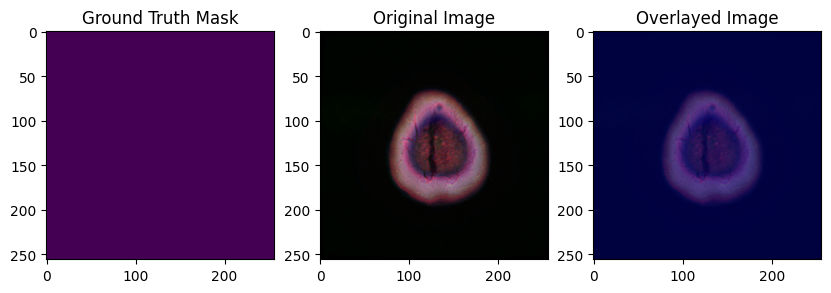

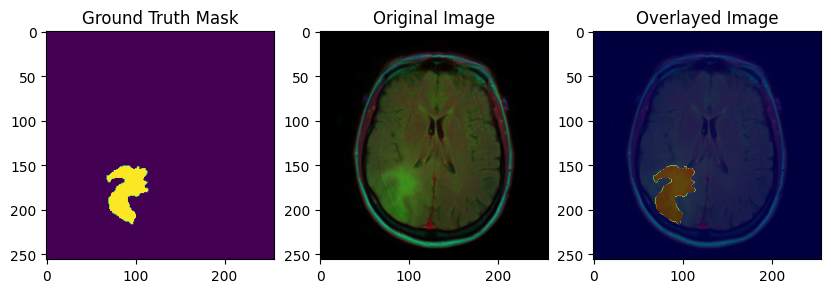

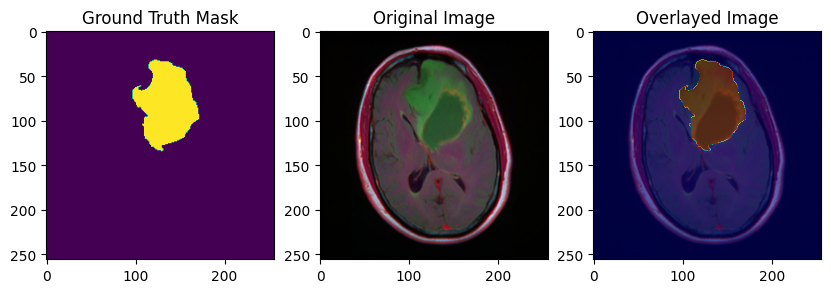

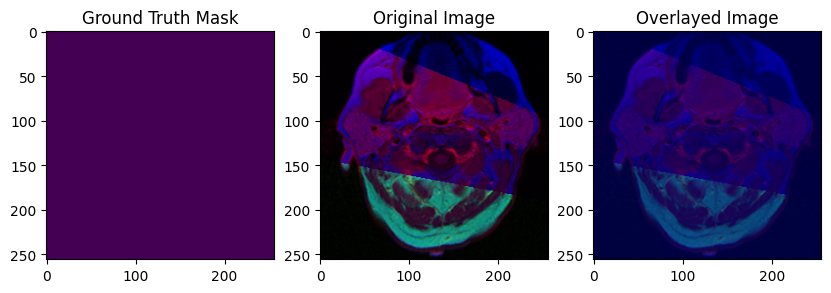

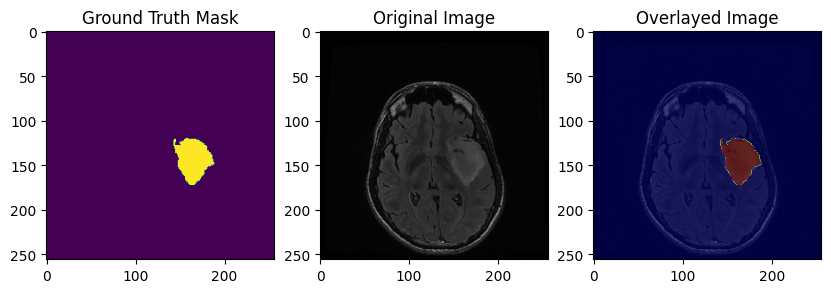

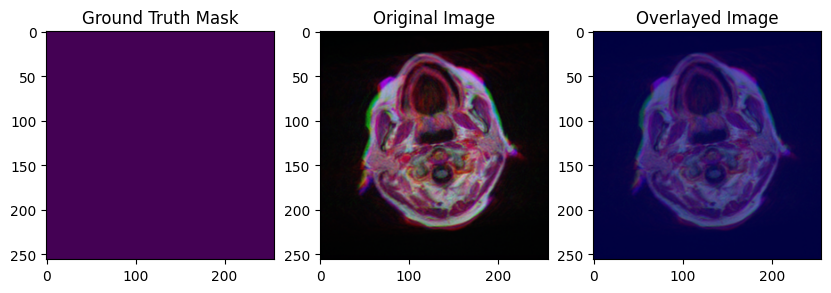

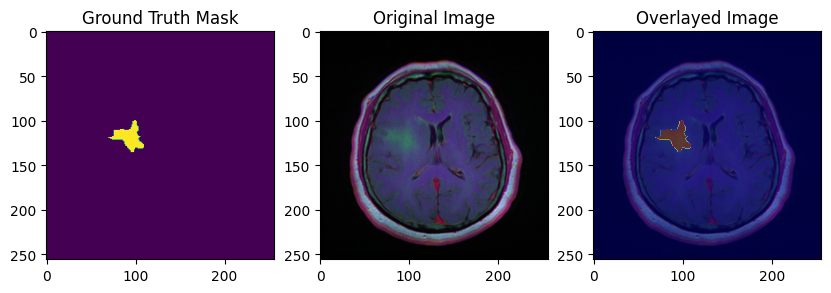

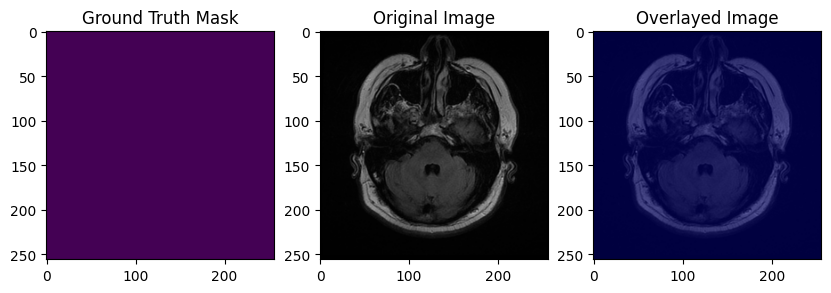

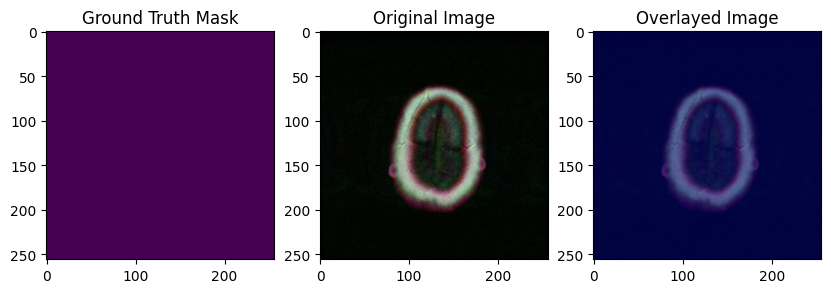

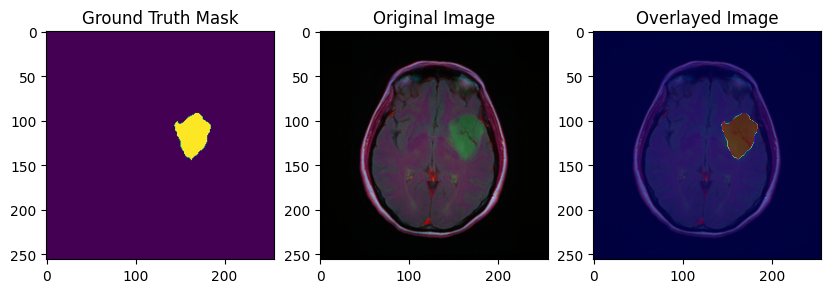

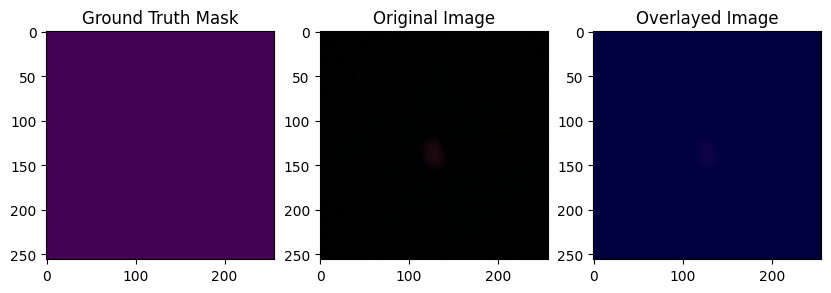

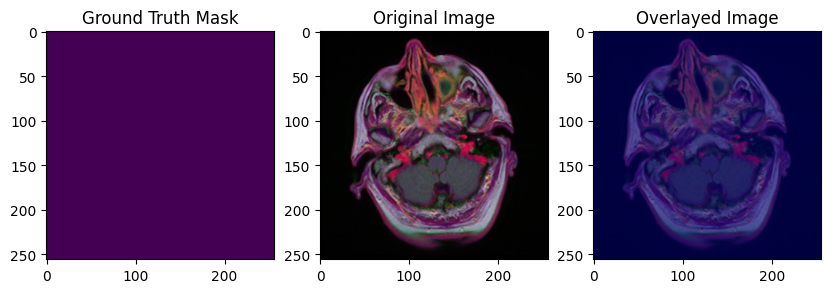

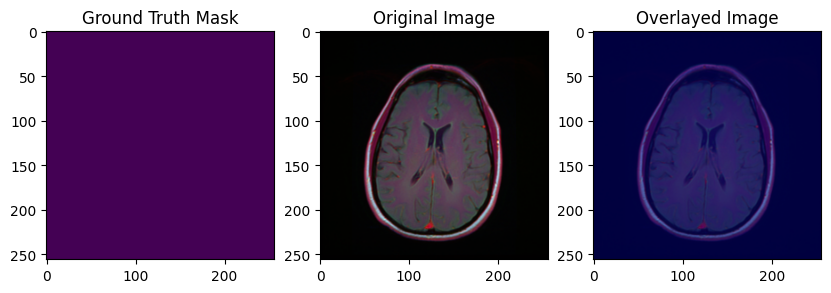

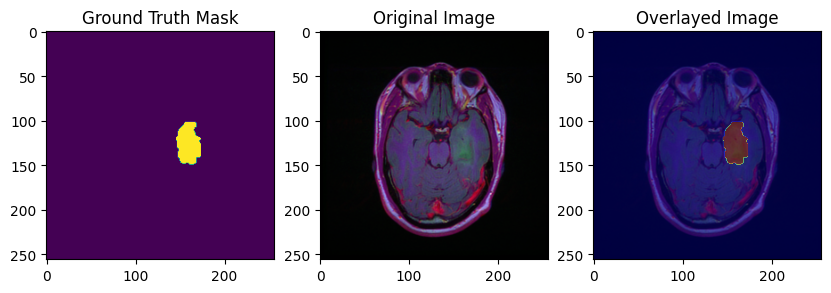

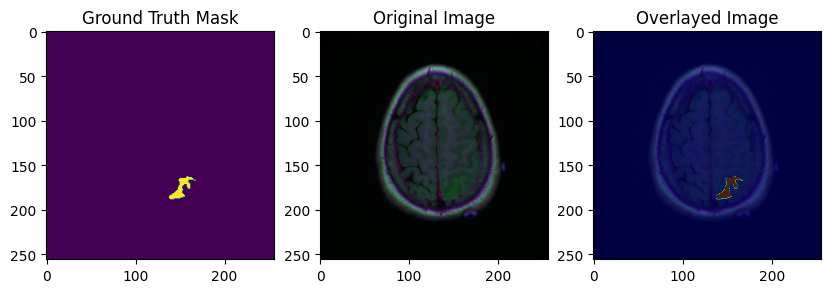

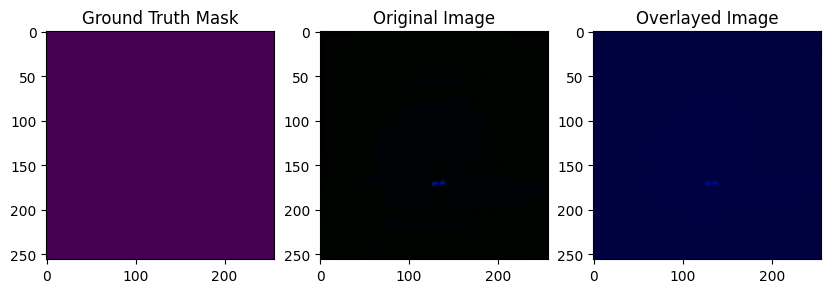

In [29]:
visualize_batch(batch=batch)  # Visualize the current batch

In [30]:
# DoubleConv: Two consecutive convolutional layers with BatchNorm and ReLU for feature extraction
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),  # First convolution layer
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),  # Second convolution layer
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True)  # ReLU activation
         )
    def forward(self, x):
        x = self.conv(x)  # Pass the input through the convolutions
        return x

# UpBlock: Upsampling block for the UNet architecture, includes a transpose convolution for upsampling
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)  # Upsampling
        self.conv = DoubleConv(in_channels, out_channels)  # Apply DoubleConv to the upsampled features
    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample x1
        x = torch.cat([x2, x1], dim=1)  # Concatenate with x2 from encoder path
        x = self.conv(x)  # Apply DoubleConv
        return x

# DownBlock: Downsampling block using MaxPool followed by DoubleConv
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.down_conv = nn.Sequential( 
            nn.MaxPool2d(2,2),  # MaxPool for downsampling
            DoubleConv(in_channels, out_channels)  # Apply DoubleConv after downsampling
         )
    def forward(self, x):
        x = self.down_conv(x)  # Apply downsample and DoubleConv
        return x

# Classifier: Final classification layer to output the result with a sigmoid activation function
class Classifier(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Classifier, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)  # 1x1 convolution for output channels
        self.sigmoid = nn.Sigmoid()  # Sigmoid to get values between 0 and 1
    def forward(self, x):
        x = self.conv(x)  # Apply 1x1 convolution
        x = self.sigmoid(x)  # Apply sigmoid activation
        x = F.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)  # Upsample the output to 256x256
        return x

# UNetMRIModel: Full UNet architecture for segmentation tasks
class UNetMRIModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNetMRIModel, self).__init__()
        self.input_encoder = DownBlock(in_channels, 64)  # Initial encoder block
        self.down1 = DownBlock(64, 128)  # Downsampling layers
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.down4 = DownBlock(512, 512)  # Deepest downsampling layer
        self.up1 = UpBlock(1024, 256)  # Upsampling blocks
        self.up2 = UpBlock(512, 128)
        self.up3 = UpBlock(256, 64)
        self.up4 = UpBlock(128, 64)
        self.classifier = Classifier(64, num_classes)  # Final classifier for segmentation output
    def forward(self, x):
        x1 = self.input_encoder(x)  # Encoder path
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)  # Decoder path (upsampling and skip connections)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.classifier(x)  # Final segmentation output
        return x

In [31]:
model = UNetMRIModel(in_channels=3, num_classes=1)

In [32]:
# Binary Cross-Entropy Loss function for segmentation tasks (pixel-wise classification)
loss_fn = nn.BCELoss()

# Adam optimizer for updating model parameters using adaptive learning rates
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs to train the model
epochs = 15

In [33]:
# Binary Cross-Entropy Loss for segmentation tasks
loss_fn = nn.BCELoss()

# Adam optimizer for updating model parameters with adaptive learning rate
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs to train the model
epochs = 15

# Training loop function for training and validating the model
def training_loop(epochs: int, 
                  optimizer: torch.optim.Optimizer, 
                  model: nn.Module, 
                  loss_fn: nn.Module, 
                  train_loader: torch.utils.data.DataLoader, 
                  valid_loader: torch.utils.data.DataLoader, 
                  device: torch.device = DEVICE):
    
    # History dictionary to store train and validation losses
    history = {'train_loss': [], 'val_loss': []}
    model.to(device)  # Move the model to the chosen device (e.g., GPU)

    # Initialize the best validation loss as infinity
    best_val_loss = float("inf")
    
    # Loop over each epoch for training and validation
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        # Running loss for training phase
        running_loss = 0
        
        model.train()  # Set model to training mode
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)  # Move data to device
            predictions = model(img)  # Model's prediction
            predictions = predictions.squeeze(1)  # Remove channel dimension
            loss = loss_fn(predictions, mask)  # Calculate loss
            running_loss += loss.item() * img.size(0)  # Accumulate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            optimizer.zero_grad()  # Zero gradients for the next step
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradient computation during validation
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        
        # Compute average losses
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        
        # Store loss in history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        # Print current epoch results
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}')
        
        # If validation loss improves, save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Validation loss improvement - Saving model!")
            torch.save(model.state_dict(), "mri_segmentation_model.pt")
    
    model.eval()  # Set model to evaluation mode
    return history  # Return the training history


In [34]:
history = training_loop(epochs, optimizer, model, loss_fn, train_loader, valid_loader)

100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


Epoch: 1/15 | Training loss: 0.1191 | Validation loss: 0.0403
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.66it/s]


Epoch: 2/15 | Training loss: 0.0328 | Validation loss: 0.0374
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.39it/s]


Epoch: 3/15 | Training loss: 0.0226 | Validation loss: 0.0384


100%|██████████| 209/209 [00:27<00:00,  7.50it/s]


Epoch: 4/15 | Training loss: 0.0186 | Validation loss: 0.0179
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.37it/s]


Epoch: 5/15 | Training loss: 0.0164 | Validation loss: 0.0159
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.57it/s]


Epoch: 6/15 | Training loss: 0.0143 | Validation loss: 0.0141
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.38it/s]


Epoch: 7/15 | Training loss: 0.0135 | Validation loss: 0.0123
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.21it/s]


Epoch: 8/15 | Training loss: 0.0128 | Validation loss: 0.0110
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:31<00:00,  6.62it/s]


Epoch: 9/15 | Training loss: 0.0117 | Validation loss: 0.0107
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.39it/s]


Epoch: 10/15 | Training loss: 0.0111 | Validation loss: 0.0109


100%|██████████| 209/209 [00:28<00:00,  7.25it/s]


Epoch: 11/15 | Training loss: 0.0099 | Validation loss: 0.0104
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.44it/s]


Epoch: 12/15 | Training loss: 0.0094 | Validation loss: 0.0151


100%|██████████| 209/209 [00:28<00:00,  7.35it/s]


Epoch: 13/15 | Training loss: 0.0083 | Validation loss: 0.0084
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.36it/s]


Epoch: 14/15 | Training loss: 0.0081 | Validation loss: 0.0104


100%|██████████| 209/209 [00:28<00:00,  7.45it/s]


Epoch: 15/15 | Training loss: 0.0083 | Validation loss: 0.0088


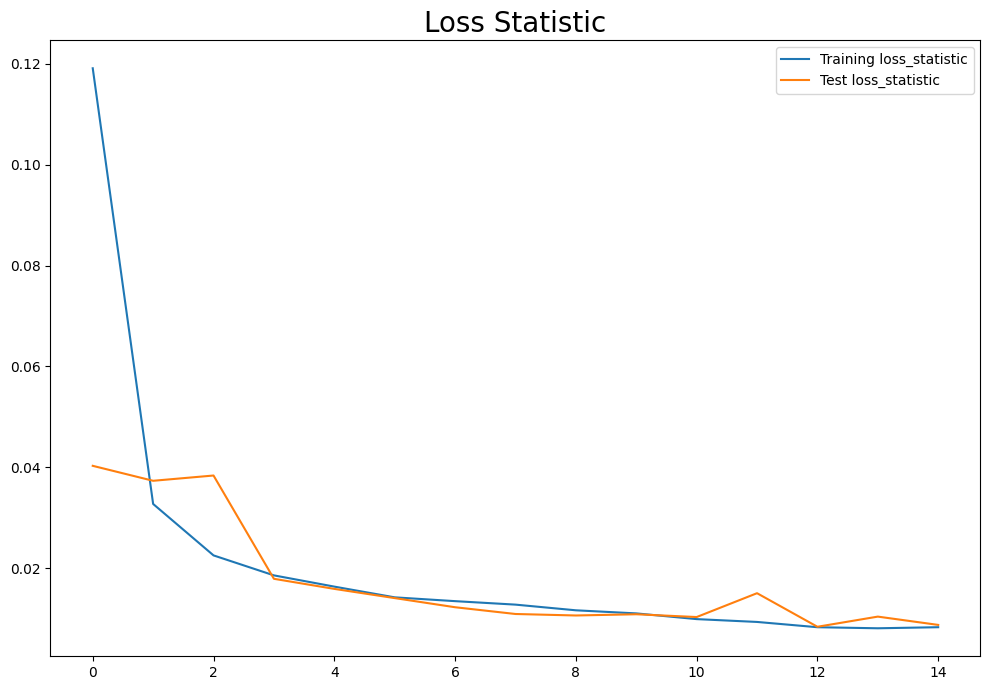

In [35]:
# Model statistics plotted with plot_statistics helper function
plot_statistics(loss_statistic = [history["train_loss"], history["val_loss"]])

In [36]:
# Initialize the UNetMRIModel with 3 input channels (RGB) and 1 output class (binary segmentation)
model = UNetMRIModel(in_channels=3, num_classes=1)

# Load the best saved model weights from a file
best_weight = torch.load("/kaggle/working/mri_segmentation_model.pt", map_location=DEVICE)

# Apply the saved weights to the model to restore the trained parameters
model.load_state_dict(best_weight)


<All keys matched successfully>

In [37]:
def evaluate_and_visualize(model, test_loader, test_dataset, loss_fn, device, n_examples=6, width=3, columns=6):
    """
    Evaluate the model on the test set, compute loss, and visualize sample predictions.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0  # Initialize variable to accumulate loss

    model.to(device)  # Move model to the specified device (GPU/CPU)
    
    # Create a grid of subplots to visualize results
    fig, axs = plt.subplots(4, columns, figsize=(3 * width * 3, 12), constrained_layout=True)
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i, (img, mask) in enumerate(test_loader):
            img, mask = img.to(device), mask.to(device)  # Move data to device

            # Forward pass: get model predictions and calculate loss
            predictions = model(img).squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)  # Accumulate loss

            if i < n_examples:  # Visualize results for a few examples
                img = img.cpu()
                mask = mask.cpu()
                prediction = predictions[0].cpu()
                prediction = torch.where(prediction > 0.5, 1, 0).float()  # Convert predictions to binary

                # Plot the original image, ground truth mask, model prediction, and overlayed image
                axs[0, i].imshow(img[0].permute(1, 2, 0))
                axs[0, i].set_title("Original Image")
                axs[0, i].axis("off")

                axs[1, i].imshow(mask[0], cmap="gray")
                axs[1, i].set_title("Ground Truth Mask")
                axs[1, i].axis("off")

                axs[2, i].imshow(prediction, cmap="gray")
                axs[2, i].set_title("Model Prediction")
                axs[2, i].axis("off")

                # Overlay ground truth and prediction on the original image
                img_with_overlay = img[0].permute(1, 2, 0).numpy()
                gt_overlay = np.zeros_like(img_with_overlay)
                pred_overlay = np.zeros_like(img_with_overlay)

                gt_overlay[mask[0].bool()] = [1, 0, 0]  # Red for ground truth
                pred_overlay[prediction.bool()] = [0, 0, 1]  # Blue for prediction

                img_with_overlay = np.clip(img_with_overlay + gt_overlay + pred_overlay, 0, 1)

                axs[3, i].imshow(img_with_overlay)
                axs[3, i].set_title("Image with Overlay")
                axs[3, i].axis("off")
                
                axs[3, i].imshow(gt_overlay, alpha=0.2)  # Display overlay with transparency
                axs[3, i].imshow(pred_overlay, alpha=0.2)

        # Compute the average loss for the test set
        loss = running_loss / len(test_dataset)
        print(f'Test Loss: {loss:.4f}')

    plt.show()  # Show the plots


In [38]:
#Hybrid model - with patient parameters
#display the number of missing values per column in the DataFrame df
missing_values_count = df.isnull().sum()
missing_values_count

Patient                        0
RNASeqCluster                749
MethylationCluster            28
miRNACluster                   0
CNCluster                    139
RPPACluster                  477
OncosignCluster              276
COCCluster                     0
histological_type             88
neoplasm_histologic_grade     88
tumor_tissue_site             88
laterality                    88
tumor_location                88
gender                        88
age_at_initial_pathologic     88
race                         108
ethnicity                    230
death01                       88
image                          0
mask                           0
dtype: int64

In [39]:
#fill missing values in the DataFrame df
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

df_imputted = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [40]:
missing_values_count = df_imputted.isnull().sum()
missing_values_count

Patient                      0
RNASeqCluster                0
MethylationCluster           0
miRNACluster                 0
CNCluster                    0
RPPACluster                  0
OncosignCluster              0
COCCluster                   0
histological_type            0
neoplasm_histologic_grade    0
tumor_tissue_site            0
laterality                   0
tumor_location               0
gender                       0
age_at_initial_pathologic    0
race                         0
ethnicity                    0
death01                      0
image                        0
mask                         0
dtype: int64

In [41]:
df_imputted.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01,image,mask
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
1,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
2,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
4,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...


In [42]:
#prepare data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_for_normalization = df_imputted.drop(columns=["Patient", "image", "mask"])
df_normalized = pd.DataFrame(scaler.fit_transform(df_for_normalization), columns=df_for_normalization.columns)
tensor_data = torch.tensor(df_normalized.values, dtype=torch.float32)

In [43]:
# FiLM module applies feature-wise scaling and shifting (gamma and beta) to image features based on metadata input.

class FiLM(nn.Module):
    def __init__(self, metadata_dim, feature_dim):
        super(FiLM, self).__init__()
        self.scale = nn.Linear(metadata_dim, feature_dim)  # computes gamma
        self.shift = nn.Linear(metadata_dim, feature_dim)  # computes beta
    
    def forward(self, x, metadata):
        gamma = self.scale(metadata).unsqueeze(-1).unsqueeze(-1)
        beta = self.shift(metadata).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta  # applies FiLM transformation

# MetadataProcessor transforms metadata into a feature vector that can be used by the model.

class MetadataProcessor(nn.Module):
    def __init__(self, metadata_dim, feature_dim):
        super(MetadataProcessor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.Linear(64, feature_dim),
            nn.ReLU()
        )
    
    def forward(self, metadata):
        return self.fc(metadata)

In [44]:
# UNetMRIHybridModel combines MRI image features with patient metadata for better tumor segmentation.
# Metadata is processed and merged into the bottleneck layer to guide the decoding path.

class UNetMRIHybridModel(nn.Module):
    def __init__(self, in_channels, num_classes, metadata_dim):
        super(UNetMRIHybridModel, self).__init__()
        # Encoder: extract features from MRI images
        self.input_encoder = DownBlock(3, 64)
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.down4 = DownBlock(512, 512)

        # Process metadata
        self.metadata_processor = MetadataProcessor(metadata_dim, 512)
        self.film = FiLM(metadata_dim, 512)

        # Decoder: upsample and combine features
        self.up1 = UpBlock(1024, 256)
        self.up2 = UpBlock(512, 128)
        self.up3 = UpBlock(256, 64)
        self.up4 = UpBlock(128, 64)

        # Final classification layer
        self.classifier = Classifier(64, num_classes)

    def forward(self, x, metadata):
        # Encoder path
        x1 = self.input_encoder(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Metadata integration
        metadata_features = self.metadata_processor(metadata)  # shape: (batch_size, 512)
        metadata_features = metadata_features.unsqueeze(-1).unsqueeze(-1)  # shape: (batch_size, 512, 1, 1)
        metadata_features = metadata_features.expand(-1, -1, x5.shape[2], x5.shape[3])  # shape: (batch_size, 512, H, W)

        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output
        x = self.classifier(x)
        return x

In [45]:
hybrid_model = UNetMRIHybridModel(in_channels=3, num_classes=1, metadata_dim=df_normalized.shape[1])

In [46]:
# Trains a hybrid UNet model using image and metadata inputs, tracks losses, and saves the best model
def hybrid_training_loop(epochs: int,
                  optimizer: torch.optim.Optimizer,
                  model: nn.Module,
                  loss_fn: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  valid_loader: torch.utils.data.DataLoader,
                  device: torch.device = DEVICE):
    
    history = {'train_loss': [], 'val_loss': []}
    model.to(device)

    best_val_loss = float("inf")
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask, metadata = data
            img, mask, metadata = img.to(device), mask.to(device), metadata.to(device)
            predictions = model(img, metadata)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask, metadata = data
                img, mask, metadata = img.to(device), mask.to(device), metadata.to(device)
                predictions = model(img, metadata)
                predictions = predictions.squeeze(1)
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Validation loss improvement - Saving model!")
            torch.save(model.state_dict(), "mri_segmentation_model_hybrid.pt")
    
    model.eval()
    return history

In [47]:
train_dataset_hybrid = MRI_Dataset(train_df, transform, tensor_data)
valid_dataset_hybrid = MRI_Dataset(valid_df, metadata_tensor=tensor_data)
test_dataset_hybrid = MRI_Dataset(test_df, metadata_tensor=tensor_data)

batch_size = 16

train_loader = DataLoader(train_dataset_hybrid, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_hybrid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

In [48]:
batch = next(iter(train_loader))
images, masks, metadatas = batch
len(batch)

3

In [49]:
history = hybrid_training_loop(epochs, optimizer, hybrid_model, loss_fn, train_loader, valid_loader)

100%|██████████| 209/209 [00:27<00:00,  7.69it/s]


Epoch: 1/15 | Training loss: 0.6221 | Validation loss: 0.6277
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:28<00:00,  7.43it/s]


Epoch: 2/15 | Training loss: 0.6221 | Validation loss: 0.6276
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.70it/s]


Epoch: 3/15 | Training loss: 0.6221 | Validation loss: 0.6274
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.48it/s]


Epoch: 4/15 | Training loss: 0.6221 | Validation loss: 0.6274


100%|██████████| 209/209 [00:27<00:00,  7.73it/s]


Epoch: 5/15 | Training loss: 0.6221 | Validation loss: 0.6257
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.51it/s]


Epoch: 6/15 | Training loss: 0.6222 | Validation loss: 0.6261


100%|██████████| 209/209 [00:26<00:00,  7.80it/s]


Epoch: 7/15 | Training loss: 0.6220 | Validation loss: 0.6277


100%|██████████| 209/209 [00:27<00:00,  7.69it/s]


Epoch: 8/15 | Training loss: 0.6221 | Validation loss: 0.6281


100%|██████████| 209/209 [00:27<00:00,  7.71it/s]


Epoch: 9/15 | Training loss: 0.6222 | Validation loss: 0.6267


100%|██████████| 209/209 [00:27<00:00,  7.64it/s]


Epoch: 10/15 | Training loss: 0.6222 | Validation loss: 0.6263


100%|██████████| 209/209 [00:27<00:00,  7.74it/s]


Epoch: 11/15 | Training loss: 0.6222 | Validation loss: 0.6264


100%|██████████| 209/209 [00:27<00:00,  7.66it/s]


Epoch: 12/15 | Training loss: 0.6221 | Validation loss: 0.6286


100%|██████████| 209/209 [00:27<00:00,  7.73it/s]


Epoch: 13/15 | Training loss: 0.6222 | Validation loss: 0.6296


100%|██████████| 209/209 [00:27<00:00,  7.70it/s]


Epoch: 14/15 | Training loss: 0.6222 | Validation loss: 0.6240
Validation loss improvement - Saving model!


100%|██████████| 209/209 [00:27<00:00,  7.69it/s]


Epoch: 15/15 | Training loss: 0.6221 | Validation loss: 0.6273


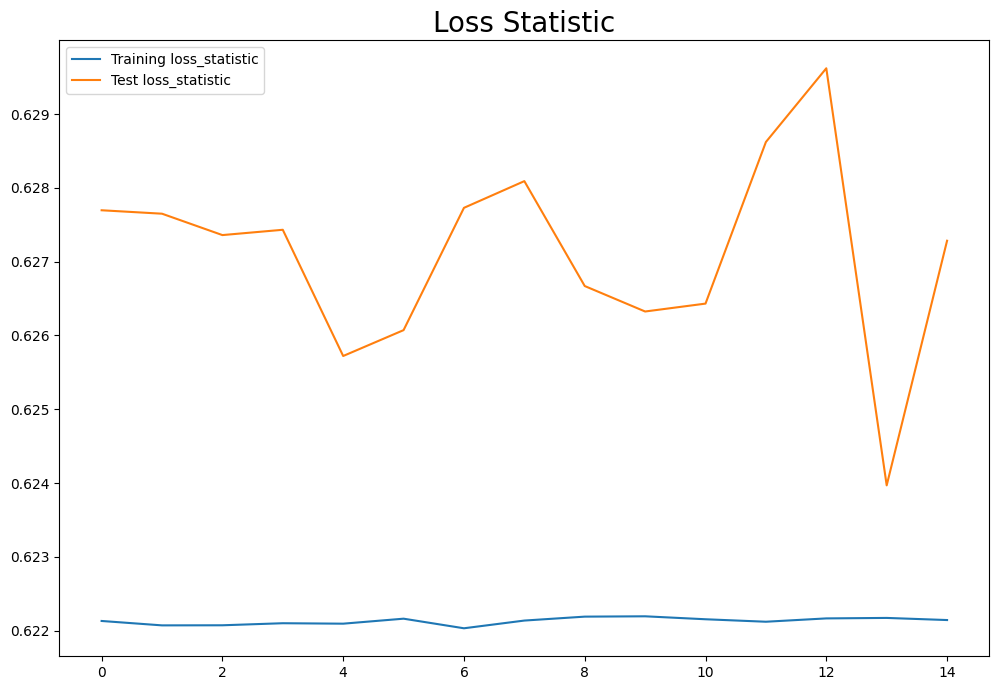

In [50]:
# Model statistics plotted with plot_statistics helper function
plot_statistics(loss_statistic = [history["train_loss"], history["val_loss"]])